# N本腕バンディットの実験
greedy手法とepsilon-greedy手法、softmax行動選択を比較

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import mython

In [51]:
class NArmBandit:
    """N本腕バンディット。
    各行動(a)の報酬Q(a)は、平均Q*(a) (真の報酬), 分散1のガウス分布に従っているとする
    Args:
        n (int) : 腕(行動)の数
        std_dev0 (float) : 各行動の真の報酬の分布の標準偏差
        std_dev1 (float) : 各試行における報酬の分布の標準偏差
    """
    def __init__(self, n=10, std_dev0=1.0, std_dev1=1.0, **kwargs):
        self.arms = 10
        self.true_rewards = np.random.normal(0.0, std_dev0, self.arms)
        self.std_dev1 = std_dev1
        
    def get_reward(self, index):
        return np.random.normal(self.true_rewards[index], self.std_dev1)


class Agent:
    """M個のN本腕バンディット環境。
    Args:
        m (int)
        n (int)
    """
    def __init__(self, m=2000, n=10, **kwargs):
        self.bandits = [NArmBandit(n, **kwargs) for _ in range(m)]
        self.sample_rewards = [[[] for _ in range(n)] for _ in range(m)]
        self.sample_mean_reward = np.zeros((m, n))
        
    def reset(self):
        self.sample_rewards = [[[] for _ in range(len(self.sample_rewards[0]))] 
                               for _ in range(len(self.sample_rewards))]
        self.sample_mean_reward[:] = 0

    def get_rewards(self, selected_indices):
        total_reward = 0
        for i, selected_idx in enumerate(selected_indices):
            reward = self.bandits[i].get_reward(selected_idx)
            self.sample_rewards[i][selected_idx].append(reward)
            self.sample_mean_reward[i, selected_idx] = np.mean(
                self.sample_rewards[i][selected_idx])
            total_reward += reward
        return total_reward

class Client:
    """ある戦略に沿ってM個のN本腕バンディットの報酬を獲得する
    """
    def __init__(self, m=2000, n=10, k=1000, **kwargs):
        self.agent = Agent(m, n, **kwargs)
        self.rewards = []
        self.m = m
        self.k = k
        
    def run(self):
        """k回の試行を行う
        """
        self.agent.reset()
        self.rewards = []
        for i in tqdm(range(self.k)):
            reward = self.agent.get_rewards(self.select_indices())
            self.rewards.append(reward / self.m)
            
    def select_indices(self):
        """m個のN本腕バンディットについて、それぞれどの腕を選択するかを計算する
        Return : list of int (バンディットで選択した腕のindexを記載した長さmの配列)
        """
        raise NotImplemented
        
        
class GreedyClient(Client):
    def select_indices(self):
        return self.agent.sample_mean_reward.argmax(axis=1)
    
    
class EpsilonGreedyClient(GreedyClient):
    def __init__(self, m=2000, n=10, k=1000, epsilon=0.1, **kwargs):
        super().__init__(m, n, k, **kwargs)
        self.epsilon = epsilon
        
    def select_indices(self):
        indices = super().select_indices()
        for idx, bandit in enumerate(self.agent.bandits):
            if np.random.rand() < self.epsilon:
                indices[idx] = np.random.randint(bandit.arms)
        return indices
    
    
class SoftmaxClient(Client):
    def __init__(self, m=2000, n=10, k=1000, tau=1.0, **kwargs):
        super().__init__(m, n, k, **kwargs)
        self.n = n
        self.tau = tau
        
    def select_indices(self):
        indices = np.zeros(self.m, dtype=int)
        softmax = np.exp(self.agent.sample_mean_reward / self.tau)
        softmax_denomis = softmax.sum(axis=1, keepdims=True)
        probs = softmax / softmax_denomis
        choices = [i for i in range(self.n)]
        for idx in range(self.m):
            indices[idx] = np.random.choice(choices, p=probs[idx])
        return indices

## 各手法の比較(1)
epsilon greedyが最も良い結果が得られている。  
softmax行動選択の結果が悪いのは各行動の報酬がほとんど等しい(平均0、標準偏差1)ことで、
softmaxの計算で差が出にくなっているためか?

In [17]:
client = GreedyClient()
eg_client = EpsilonGreedyClient()
sm_client = SoftmaxClient()

client.run()
eg_client.run()
sm_client.run()

100%|██████████| 1000/1000 [00:45<00:00, 21.98it/s]


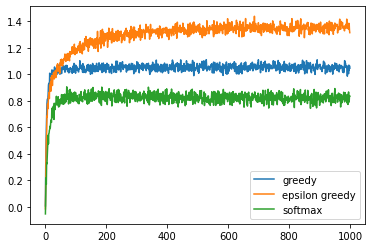

In [29]:
plt.plot(client.rewards, label="greedy")
plt.plot(eg_client.rewards, label="epsilon greedy")
plt.plot(sm_client.rewards, label="softmax")
plt.legend()

## softmax行動選択のパラメータチューニング
各手法の比較(1)でsoftmax行動選択の結果が悪かったので、パラメータチューニングで精度改善するか検証。  
各行動の報酬の差がほとんどないことが結果に影響していると考えられたので、
温度パラメータを小さくすることで結果の改善を狙う。  
-> 結果としては改善していたが、epsilon-greedyには及ばなかった。

In [41]:
taus = [0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 5.0]
clients = []
for tau in taus:
    c = SoftmaxClient(tau=tau)
    c.run()
    clients.append(c)

100%|██████████| 1000/1000 [01:02<00:00, 15.96it/s]


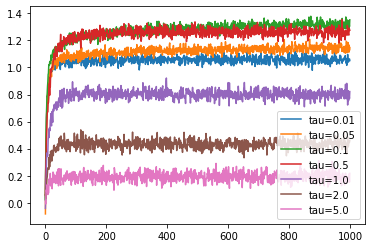

In [43]:
for tau, clt in zip(taus, clients):
    plt.plot(clt.rewards, label="tau={}".format(tau))
plt.legend()

## 各手法の比較(2)
各種法の比較(1)でsoftmax行動選択の結果が良くなかったのでパラメータを変更して再度実験。  
各行動の報酬に差が出るように、各行動の報酬を平均0、標準偏差10で初期化して3つの手法を比較。  
softmax行動選択がダントツで良い結果。

In [52]:
params = {
    "std_dev0": 10,
    "std_dev1": 1
}
tau = 0.1

gd_client = GreedyClient()
eg_client = EpsilonGreedyClient()
sm_client = SoftmaxClient(tau=tau, **params)

gd_client.run()
eg_client.run()
sm_client.run()

100%|██████████| 1000/1000 [01:26<00:00, 11.57it/s]


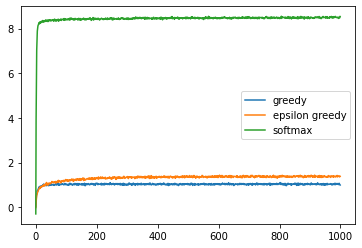

In [53]:
plt.plot(gd_client.rewards, label="greedy")
plt.plot(eg_client.rewards, label="epsilon greedy")
plt.plot(sm_client.rewards, label="softmax")
plt.legend()